# Token Network Projections Analysis 

This Notebook shows general properties of the validated Token network projections

In [2]:
import pandas as pd
import numpy as np
import networkx as nx 

import matplotlib.pyplot as plt
from ast import literal_eval

from os.path import join
import os

# from token_projection.token_projection import *
# from utilities.metrics_and_tests import * 
# from utilities.utils import * 

from dotenv import load_dotenv
load_dotenv()  

path = os.environ['DATA_DIRECTORY']
covalent_key = os.environ['COVALENTHQ_API_KEY']
df_snapshots = pd.read_csv('../data/snapshot_selection.csv')
df_snapshots['Date'] = pd.to_datetime(df_snapshots['Date'])  # Ensure dates are in datetime format
df_tokens = pd.read_csv("../data/final_token_selection.csv")

# Convert DataFrame to a dictionary where keys are addresses and values are symbols
address_to_symbol = pd.Series(df_tokens['symbol'].values, index=df_tokens['address']).to_dict()
address_to_symbol

# df_tokens = pd.read_csv('../assets/df_final_token_selection_20230813.csv')

# remove burner addresses 
known_burner_addresses = ['0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000001',
                        '0x0000000000000000000000000000000000000002',
                        '0x0000000000000000000000000000000000000003',
                        '0x0000000000000000000000000000000000000004',
                        '0x0000000000000000000000000000000000000005',
                        '0x0000000000000000000000000000000000000006',
                        '0x0000000000000000000000000000000000000007',
                        '0x000000000000000000000000000000000000dead']

### NOTE: YOU NEED TO RE-RUN TOKEN VALIDATION --> REMOVAL OF BITDAO CAUSED THIS.
### ALSO DOUBLE CHECK THAT BITDAO IS THE PROBLEM AND NOT AURA !!! 


In [3]:
import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from src.analysis.clique_analysis import * 
from src.utilities.metrics_and_tests import jaccard_similarity
from src.visualisations.token_network_projections_visualisations import * 

## Visualise Network Projection of Snapshot over time

In [4]:
input_directory = os.path.join(path, '../data/validated_token_projection_graphs')
graphs, dates = load_token_graphs_from_snapshots(df_snapshots, input_directory)

Graph file for snapshot 7962629 does not exist.
Graph file for snapshot 8155117 does not exist.
Graph file for snapshot 8354625 does not exist.
Graph file for snapshot 8553607 does not exist.
Graph file for snapshot 8745378 does not exist.
Graph file for snapshot 8938208 does not exist.
Graph file for snapshot 9110216 does not exist.
Graph file for snapshot 9285458 does not exist.
Graph file for snapshot 9487426 does not exist.
Graph file for snapshot 9676110 does not exist.
Graph file for snapshot 9877036 does not exist.
Graph file for snapshot 10070789 does not exist.
Graph file for snapshot 10270349 does not exist.
Graph file for snapshot 10467362 does not exist.
Graph file for snapshot 10664157 does not exist.
Graph file for snapshot 10866666 does not exist.
Graph file for snapshot 11060222 does not exist.
Graph file for snapshot 11262275 does not exist.
Graph file for snapshot 11457486 does not exist.


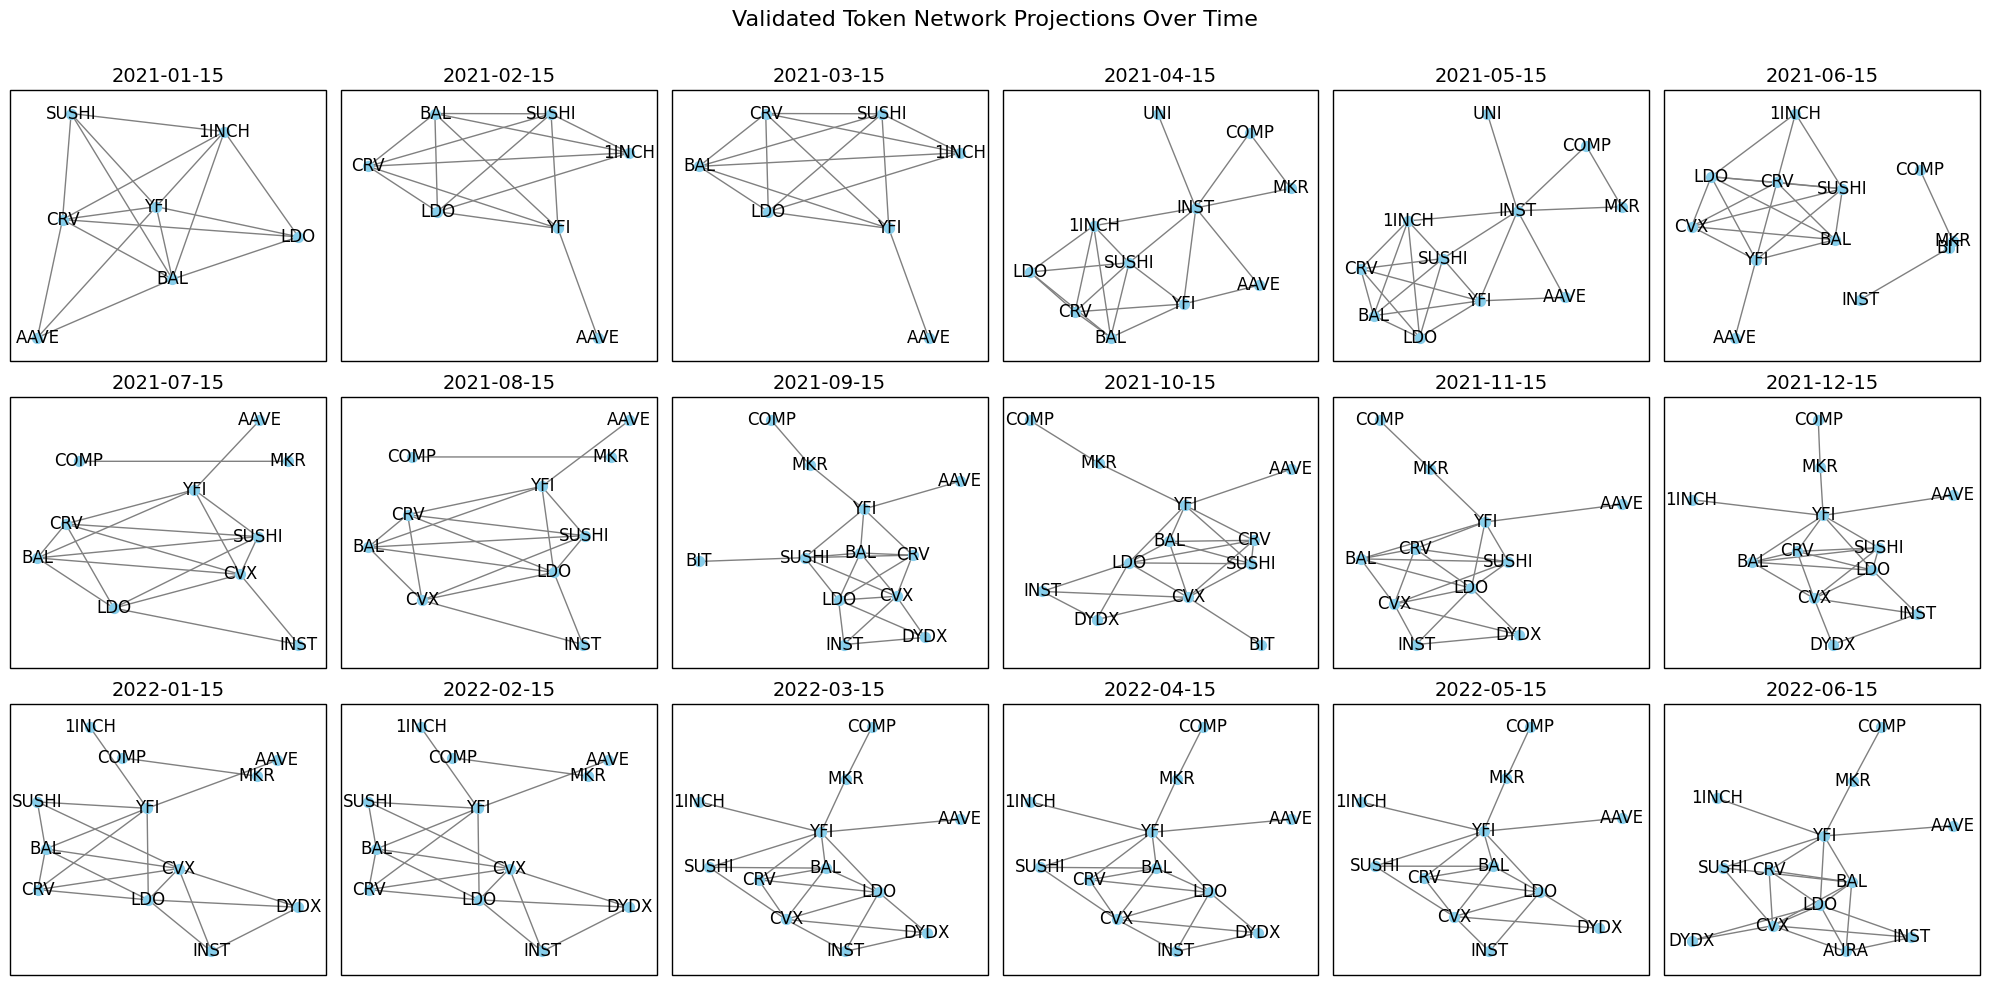

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd

visualize_network_grid(graphs, dates, address_to_symbol, output_directory='../output/token_network_projections/', layout=nx.kamada_kawai_layout)


## Jaccard Similarity of Validated Network Projection over time 

In [6]:
similarity_matrix, snapshot_list = calculate_similarity_matrix(graphs)

# plot_similarity_heatmap(similarity_matrix, snapshot_list, dates, output_directory='../output/token_network_projections/')

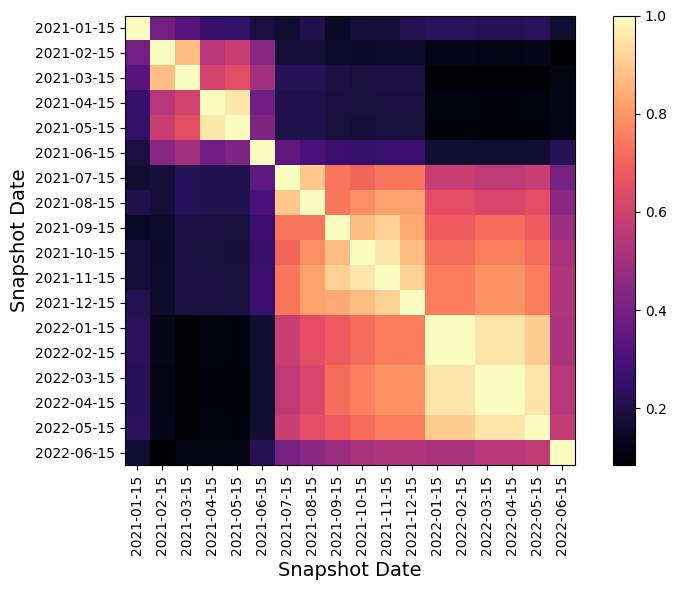

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

def standardized_figure_plot(data, x_labels, y_labels, output_filename, output_directory):
    # Set a figure size that typically fits well in LaTeX documents
    fig, ax = plt.subplots(figsize=(10, 6))  # More manageable dimensions
    
    # Plot the data (using heatmap as an example)
    cax = ax.matshow(data, interpolation='nearest', cmap='magma')
    
    # Add a color bar with consistent positioning and size
    fig.colorbar(cax, fraction=0.046, pad=0.04)

    # Set axis labels with reasonable font sizes (big enough but not too large)
    ax.set_xlabel('Snapshot Date', fontsize=14)
    ax.set_ylabel('Snapshot Date', fontsize=14)
    
    # Set tick labels for x and y axes with slightly smaller font sizes
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=90, fontsize=10)
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=10)

    # Position x-axis ticks at the bottom
    ax.xaxis.set_ticks_position('bottom')

    # Use tight layout to reduce whitespace
    plt.tight_layout()

    # Ensure output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Save figure in PDF format with bounding box tight to content
    plt.savefig(os.path.join(output_directory, output_filename), format='pdf', dpi=300, bbox_inches='tight')
    
    # Optional: Show the figure (can be commented out when running in batch mode)
    # plt.show()

# Example usage (assuming similarity_matrix, snapshot_list, and dates are defined)
standardized_figure_plot(
    data=similarity_matrix,
    x_labels=[dates[snapshot] for snapshot in snapshot_list],
    y_labels=[dates[snapshot] for snapshot in snapshot_list],
    output_filename="jaccard_similarity.pdf",
    output_directory='../output/token_network_projections/'
)


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

def compute_token_absolute_ownership(
    path,
    df_snapshots,
    df_tokens,
    known_burner_addresses,
    min_block_height=11659570
):
    """
    Load the CSV data for snapshots >= min_block_height, filter relevant addresses/tokens,
    and return a DataFrame of token ownership counts (rows=token_name, columns=Date).
    
    Args:
        path (str): Base path where the token balance CSV files live.
        df_snapshots (pd.DataFrame): DataFrame with 'Block Height' and 'Date' columns.
        df_tokens (pd.DataFrame): DataFrame containing token addresses ('address') and names ('name').
        known_burner_addresses (list/iterable): Addresses to exclude from analysis.
        min_block_height (int): Minimum block height to filter on snapshots.
    
    Returns:
        pd.DataFrame: The computed ownership table (index=token names, columns=Dates).
    """
    # Filter relevant block heights
    relevant_snapshots = df_snapshots[df_snapshots['Block Height'] >= min_block_height]
    
    # This will hold series of unique-holding addresses for each snapshot
    ownership_list = []
    
    for _, row in relevant_snapshots.iterrows():
        snapshot = row['Block Height']
        date_str = row['Date']
        
        # Construct file path
        file_path = os.path.join(
            path, f"token_holder_snapshot_balance_{snapshot}.csv"
        )
        
        # Read the snapshot
        ddf = pd.read_csv(file_path, index_col=[0])
        ddf = ddf[ddf.value > 0]  # Consider non-zero balances at snapshot
        
        # Filter only the tokens we care about & exclude burner addresses
        ddf.reset_index(inplace=True)
        ddf = ddf[ddf.token_address.isin(df_tokens.address)]
        ddf = ddf[~ddf.address.isin(known_burner_addresses)]
        
        # Calculate the number of unique addresses holding each token
        absolute_ownership = ddf.groupby('token_address')['address'].nunique()
        ownership_list.append(absolute_ownership.rename(date_str))
    
    # Concatenate along columns (each Date becomes a column)
    df_token_absolute_ownership = pd.concat(ownership_list, axis=1).fillna(0)
    
    # Map token addresses -> token names
    token_name_dict = dict(zip(df_tokens['address'], df_tokens['name']))
    df_token_absolute_ownership['name'] = df_token_absolute_ownership.index.map(token_name_dict)
    df_token_absolute_ownership.set_index('name', inplace=True)
    
    return df_token_absolute_ownership





# --- Example usage ---

# 1. Compute the DataFrame (one-time, expensive part):
df_token_absolute_ownership = compute_token_absolute_ownership(
    path="../data/snapshot_token_balance_tables/",
    df_snapshots=df_snapshots,
    df_tokens=df_tokens,
    known_burner_addresses=known_burner_addresses
)

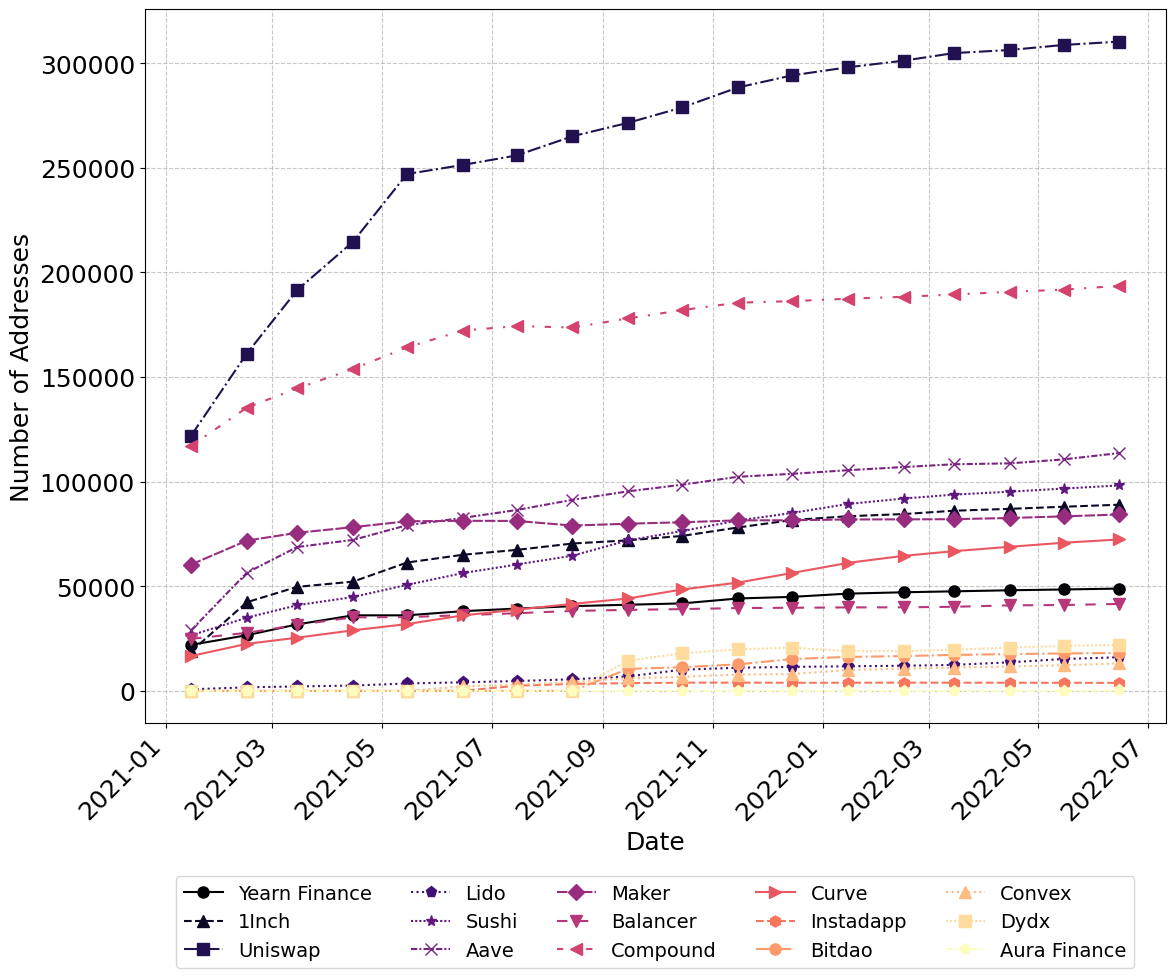

In [43]:
def plot_absolute_token_ownership_over_time(
    df_token_absolute_ownership,
    output_directory="../output/token_network_projections/",
    output_filename="token_ownership_over_time.pdf"
):
    """
    Given a precomputed DataFrame of token ownership over time (index=token_name, columns=Dates),
    create a line plot showing the number of addresses holding each token.
    
    Args:
        df_token_absolute_ownership (pd.DataFrame): Ownership table (index=token name, columns=dates).
        output_directory (str): Where to save the plot.
        output_filename (str): Name of the PDF to save.
    """
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 10))  # Wider than the default 6.4 x 4.8
    
    # Prepare a color map
    num_lines = len(df_token_absolute_ownership.index)
    color_map = plt.cm.magma(np.linspace(0, 1, num_lines))
    
    # Define line styles and markers (cycle through them if there are many tokens)
    line_styles = ['-', '--', '-.', ':', (0, (1, 1)), (0, (3, 1, 1, 1)),
                   (0, (5, 1)), (0, (5, 5)), (0, (3, 5, 1, 5))]
    markers = ['o', '^', 's', 'p', '*', 'x', 'D', 'v', '<', '>', 'h']
    
    # Plot each token as a separate line
    for i, (token_name, row) in enumerate(df_token_absolute_ownership.iterrows()):
        style = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        
        ax.plot(
            df_token_absolute_ownership.columns,  # the Dates
            row,                                  # the ownership counts
            linestyle=style,
            marker=marker,
            markersize=8,
            label=token_name,
            color=color_map[i]
        )
    
    # Axis labels
    ax.set_xlabel('Date', fontsize=18)
    ax.set_ylabel('Number of Addresses', fontsize=18)
    
    # Rotate x-tick labels if needed
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Ticks style
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    
    # Add a grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Legend
    ax.legend(
        # title="Token",
        bbox_to_anchor=(0.5, -.2),  # Center the legend below the chart
        loc="upper center",  # Place legend below
        fontsize=14,
        # title_fontsize=12,
        ncol=5  # Split the legend into multiple columns if there are many tokens
    )
    
    # Tight layout
    plt.tight_layout()
    
    # Ensure output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Save
    output_path = os.path.join(output_directory, output_filename)
    plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')
    
    # Optionally show
    plt.show()


# 2. Plot (quick re-plot any time, no heavy CSV loading):
plot_absolute_token_ownership_over_time(
    df_token_absolute_ownership,
    output_directory="../output/token_network_projections/",
    output_filename="token_ownership_over_time.pdf"
)